<a href="https://colab.research.google.com/github/raphael-fawaz/Financial-Markets-Analysis-and-Prediction/blob/LSTM-Variations-on-DJ%2CNASDAQ%2CEGX30/Stacked_LSTM_(Dow_Jones_%26_Nasdaq)_close_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stacked-LSTM (Dow Jones & Nasdaq) - close price

In [ ]:
# pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import io

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from pandas.plotting import lag_plot

### Getting the data

In [ ]:
dow_ticker = "^DJI"
nasdaq_ticker = "^IXIC"
start_date = "2010-01-01"
end_date = "2023-12-31"
dow_data = yf.download(dow_ticker, start=start_date, end=end_date)
dow_data.to_csv("dow_data.csv")
nasdaq_data = yf.download(nasdaq_ticker, start=start_date, end=end_date)
nasdaq_data.to_csv("nasdaq_data.csv")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Dow Jones

In [ ]:
dow_data = pd.read_csv("dow_data.csv", index_col="Date", parse_dates=True)
dow_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,10430.690430,10604.969727,10430.690430,10583.959961,10583.959961,179780000
2010-01-05,10584.559570,10584.559570,10522.519531,10572.019531,10572.019531,188540000
2010-01-06,10564.719727,10594.990234,10546.549805,10573.679688,10573.679688,186040000
2010-01-07,10571.110352,10612.370117,10505.209961,10606.860352,10606.860352,217390000
2010-01-08,10606.400391,10619.400391,10554.330078,10618.190430,10618.190430,172710000


In [ ]:
dow_close = dow_data['Close'].values.reshape(-1, 1)

### Normalizing the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
dow_close_scaled = sc.fit_transform(dow_close)

### Create the sequence

In [ ]:
# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

In [ ]:
seq_length = 60  # Use 60 days of data to predict the next day's price
dow_sequences, dow_labels = create_sequences(dow_close_scaled, seq_length)

### splitting the data

In [ ]:
# Determine the index to split the data for the test set (last 60 days)
test_size = 60
train_sequences = dow_sequences[:-test_size]
test_sequences = dow_sequences[-test_size:]
train_labels = dow_labels[:-test_size]
test_labels = dow_labels[-test_size:]

## LSTM

### Train the lstm model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (train_sequences.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(train_sequences, train_labels, epochs = 100, batch_size = 32)

Epoch 1/100
107/107 [==============================] - 22s 116ms/step - loss: 0.0139
Epoch 2/100
107/107 [==============================] - 12s 116ms/step - loss: 0.0037
Epoch 3/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0029
Epoch 4/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0029
Epoch 5/100
107/107 [==============================] - 12s 116ms/step - loss: 0.0025
Epoch 6/100
107/107 [==============================] - 12s 116ms/step - loss: 0.0026
Epoch 7/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0025
Epoch 8/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0022
Epoch 9/100
107/107 [==============================] - 12s 116ms/step - loss: 0.0022
Epoch 10/100
107/107 [==============================] - 12s 116ms/step - loss: 0.0022
Epoch 11/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0019
Epoch 12/100
107/107 [==============================] - 12s 116

Epoch 94/100
107/107 [==============================] - 12s 112ms/step - loss: 7.7476e-04
Epoch 95/100
107/107 [==============================] - 12s 112ms/step - loss: 7.5363e-04
Epoch 96/100
107/107 [==============================] - 12s 112ms/step - loss: 7.5164e-04
Epoch 97/100
107/107 [==============================] - 12s 113ms/step - loss: 7.1356e-04
Epoch 98/100
107/107 [==============================] - 12s 113ms/step - loss: 7.3643e-04
Epoch 99/100
107/107 [==============================] - 12s 113ms/step - loss: 7.3380e-04
Epoch 100/100
107/107 [==============================] - 12s 112ms/step - loss: 7.4768e-04


### Predict on the test set

In [ ]:
predicted_stock_price = regressor.predict(test_sequences)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)
#real_price = sc.inverse_transform(dow_test)

2/2 [==============================] - 2s 44ms/step


### RMSE Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_labels, predicted_stock_price))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.028714385734566472


### Plotting

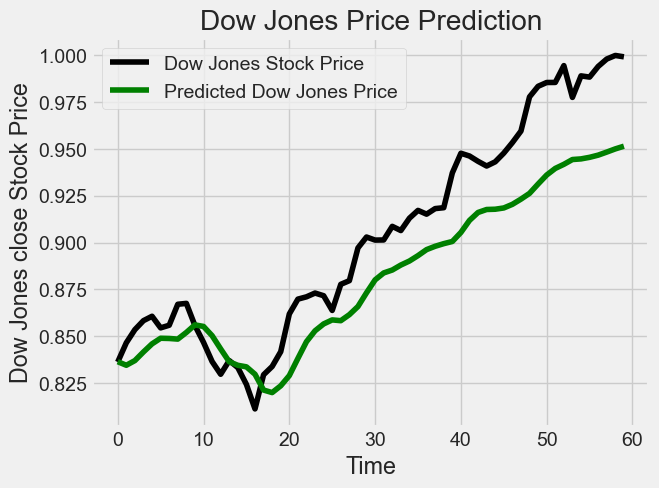

In [ ]:
plt.plot(test_labels, color = 'black', label = 'Dow Jones Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Dow Jones Price')
plt.title('Dow Jones Price Prediction')
plt.xlabel('Time')
plt.ylabel('Dow Jones close Stock Price')
plt.legend()
plt.show()

### Project the data on the future next 30 days

1/1 [==============================] - 0s 25ms/step
Predicted Dow Jones Prices for the Next 30 Days:
2023-12-30: 36375.39
2023-12-31: 36236.32
2024-01-01: 36020.34
2024-01-02: 35846.07
2024-01-03: 35719.29
2024-01-04: 35609.23
2024-01-05: 35498.32
2024-01-06: 35384.00
2024-01-07: 35270.72
2024-01-08: 35163.05
2024-01-09: 35063.00
2024-01-10: 34970.57
2024-01-11: 34884.92
2024-01-12: 34805.19
2024-01-13: 34730.68
2024-01-14: 34660.82
2024-01-15: 34595.03
2024-01-16: 34532.74
2024-01-17: 34473.38
2024-01-18: 34416.41
2024-01-19: 34361.38
2024-01-20: 34307.89
2024-01-21: 34255.59
2024-01-22: 34204.25
2024-01-23: 34153.62
2024-01-24: 34103.55
2024-01-25: 34053.91
2024-01-26: 34004.58
2024-01-27: 33955.50
2024-01-28: 33906.61


C:\Users\Rapha\AppData\Local\Temp\ipykernel_25672\949360583.py:15: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  next_dates = pd.date_range(start=last_date, periods=31, closed='right')


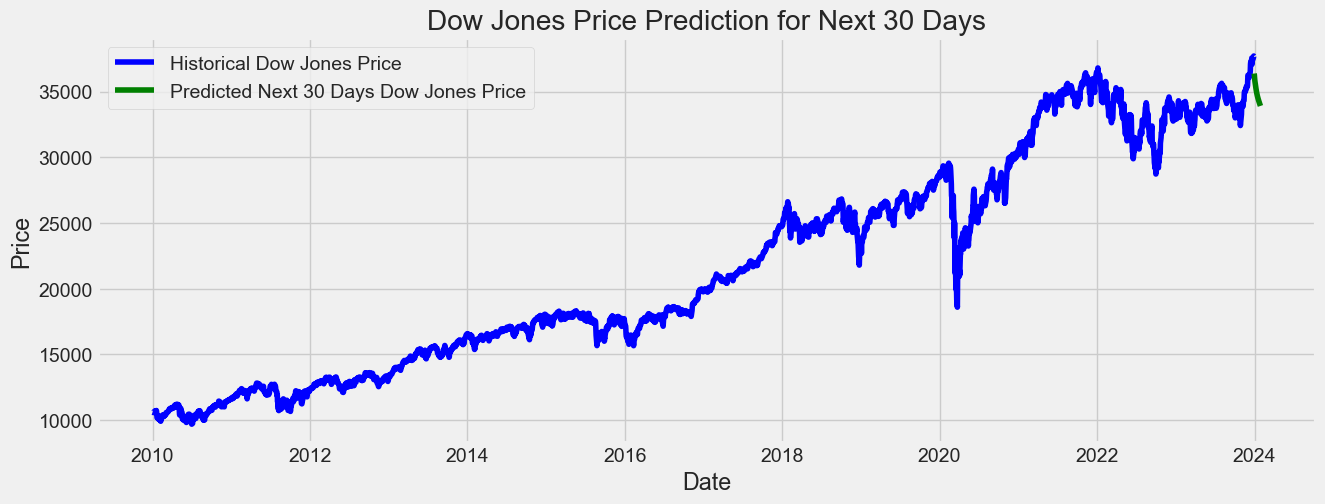

In [ ]:
# Predict the next 30 days
last_sequence = dow_close_scaled[-seq_length:]  # Last 60 days
next_30_days = []

for _ in range(30):
    next_day_pred = regressor.predict(last_sequence.reshape(1, seq_length, 1))
    next_30_days.append(next_day_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_day_pred)

# Inverse transform the predictions
next_30_days = sc.inverse_transform(np.array(next_30_days).reshape(-1, 1))

# Create a date range for the next 30 days
last_date = dow_data.index[-1]
next_dates = pd.date_range(start=last_date, periods=31, closed='right')

print("Predicted Dow Jones Prices for the Next 30 Days:")
for date, price in zip(next_dates, next_30_days):
    print(f"{date.date()}: {price[0]:.2f}")

# Plot the next 30 days predictions
plt.figure(figsize=(14, 5))
plt.plot(dow_data.index, dow_close, color='blue', label='Historical Dow Jones Price')
plt.plot(next_dates, next_30_days, color='green', label='Predicted Next 30 Days Dow Jones Price')
plt.title('Dow Jones Price Prediction for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## NASDAQ

In [ ]:
nasdaq_data = pd.read_csv("nasdaq_data.csv", index_col="Date", parse_dates=True)
nasdaq_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000


In [ ]:
nasdaq_close = nasdaq_data['Close'].values.reshape(-1, 1)
sc = MinMaxScaler(feature_range = (0,1))
nasdaq_close_scaled = sc.fit_transform(nasdaq_close)
nasdaq_sequences, nasdaq_labels = create_sequences(nasdaq_close_scaled, seq_length)

In [ ]:
# Determine the index to split the data for the test set (last 60 days)
test_size = 60
train_sequences_nasdaq = nasdaq_sequences[:-test_size]
test_sequences_nasdaq = nasdaq_sequences[-test_size:]
train_labels_nasdaq = nasdaq_labels[:-test_size]
test_labels_nasdaq = nasdaq_labels[-test_size:]

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (train_sequences_nasdaq.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(train_sequences_nasdaq, train_labels_nasdaq, epochs = 100, batch_size = 32)

Epoch 1/100
107/107 [==============================] - 22s 115ms/step - loss: 0.0115
Epoch 2/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0026
Epoch 3/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0026
Epoch 4/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0025
Epoch 5/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0023
Epoch 6/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0019
Epoch 7/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0018
Epoch 8/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0019
Epoch 9/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0018
Epoch 10/100
107/107 [==============================] - 12s 115ms/step - loss: 0.0016
Epoch 11/100
107/107 [==============================] - 12s 114ms/step - loss: 0.0014
Epoch 12/100
107/107 [==============================] - 12s 115

In [ ]:
predicted_stock_price_nasdaq = regressor.predict(test_sequences_nasdaq)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)
#real_price = sc.inverse_transform(test_labels_nasdaq)

2/2 [==============================] - 2s 31ms/step


In [ ]:
rmse = np.sqrt(mean_squared_error(test_labels_nasdaq, predicted_stock_price_nasdaq))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.01680102976579914


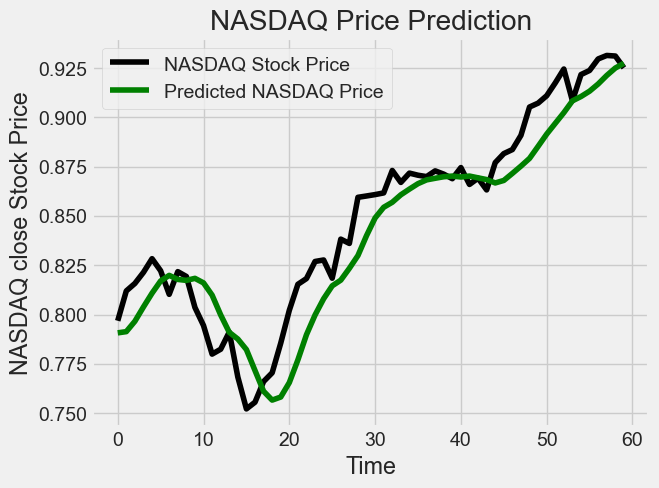

In [ ]:
plt.plot(test_labels_nasdaq, color = 'black', label = 'NASDAQ Stock Price')
plt.plot(predicted_stock_price_nasdaq, color = 'green', label = 'Predicted NASDAQ Price')
plt.title('NASDAQ Price Prediction')
plt.xlabel('Time')
plt.ylabel('NASDAQ close Stock Price')
plt.legend()
plt.show()

1/1 [==============================] - 0s 33ms/step
Predicted NASDAQ Prices for the Next 30 Days:
2023-12-30: 15048.01
2023-12-31: 15048.71
2024-01-01: 15055.19
2024-01-02: 15064.94
2024-01-03: 15073.31
2024-01-04: 15077.66
2024-01-05: 15078.24
2024-01-06: 15076.93
2024-01-07: 15075.49
2024-01-08: 15074.77
2024-01-09: 15074.80
2024-01-10: 15075.33
2024-01-11: 15076.18
2024-01-12: 15077.41
2024-01-13: 15079.17
2024-01-14: 15081.55
2024-01-15: 15084.57
2024-01-16: 15088.16
2024-01-17: 15092.20
2024-01-18: 15096.61
2024-01-19: 15101.30
2024-01-20: 15106.22
2024-01-21: 15111.29
2024-01-22: 15116.48
2024-01-23: 15121.71
2024-01-24: 15126.96
2024-01-25: 15132.15
2024-01-26: 15137.26
2024-01-27: 15142.27
2024-01-28: 15147.15


C:\Users\Rapha\AppData\Local\Temp\ipykernel_25672\3102816372.py:15: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  next_dates = pd.date_range(start=last_date, periods=31, closed='right')


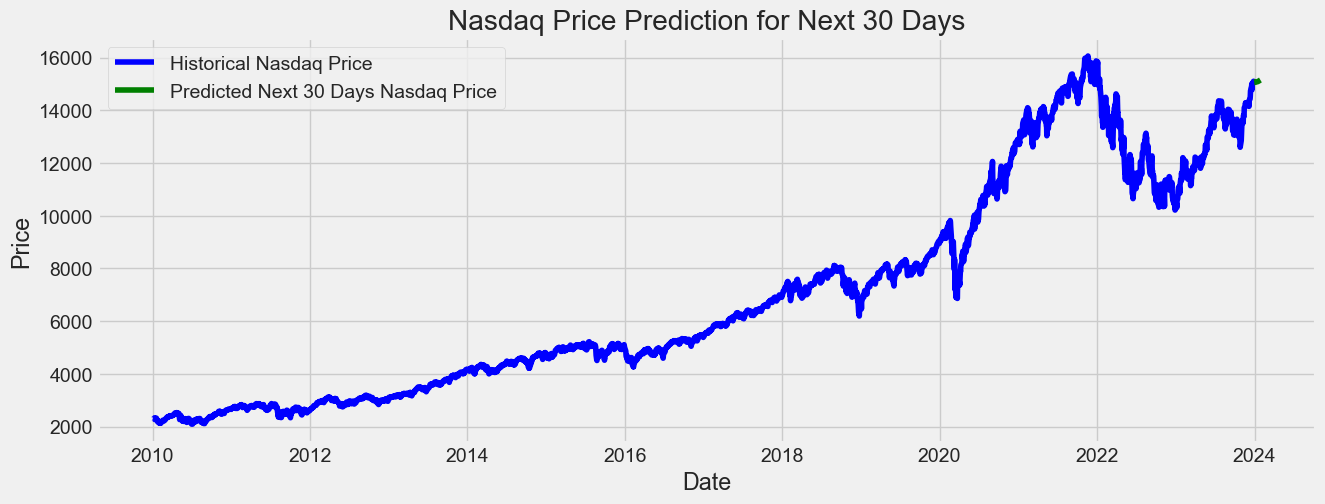

In [ ]:
# Predict the next 30 days
last_sequence = nasdaq_close_scaled[-seq_length:]  # Last 60 days
next_30_days = []

for _ in range(30):
    next_day_pred = regressor.predict(last_sequence.reshape(1, seq_length, 1))
    next_30_days.append(next_day_pred[0, 0])
    last_sequence = np.append(last_sequence[1:], next_day_pred)

# Inverse transform the predictions
next_30_days = sc.inverse_transform(np.array(next_30_days).reshape(-1, 1))

# Create a date range for the next 30 days
last_date = nasdaq_data.index[-1]
next_dates = pd.date_range(start=last_date, periods=31, closed='right')

print("Predicted NASDAQ Prices for the Next 30 Days:")
for date, price in zip(next_dates, next_30_days):
    print(f"{date.date()}: {price[0]:.2f}")

# Plot the next 30 days predictions
plt.figure(figsize=(14, 5))
plt.plot(nasdaq_data.index, nasdaq_close, color='blue', label='Historical Nasdaq Price')
plt.plot(next_dates, next_30_days, color='green', label='Predicted Next 30 Days Nasdaq Price')
plt.title('Nasdaq Price Prediction for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
nasdaq_close

array([[ 2308.41992188],
       [ 2308.70996094],
       [ 2301.09008789],
       ...,
       [15099.1796875 ],
       [15095.13964844],
       [15011.34960938]])

In [ ]:
dow_close

array([[10583.95996094],
       [10572.01953125],
       [10573.6796875 ],
       ...,
       [37656.51953125],
       [37710.1015625 ],
       [37689.5390625 ]])